# Assignment 1
In Section AE.1 in the ebook, the NN model is trained on the normal Reynolds stresses
in the boundary layer flow and then the Reynolds stresses in the two channel
flows ($Re_τ$ = 550 and $Re_τ$ = 5 200) are predicted. Do it the other way around:
use one of the channel flows as training data and predict the Reynolds stresses for
the other two flows. You need probably change the limits on y+ and ∂U+/∂y+.

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

from LoadData import *
from pathlib import Path
import numpy as np
import torch 
import sys 
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from random import randrange
from joblib import dump, load

plt.rcParams.update({'font.size': 22})
plt.interactive(True)
plt.close('all')
# Create output path
outputPath = 'Output/'
Path("Output").mkdir(parents=True, exist_ok=True)


## Get DNS/LES data for channel flow, $Re = 5200$

In [2]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re5200', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

Returning data from: FullyDevelopedChannel_Re5200. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33


## Plot to check that dissipation and production are balanced

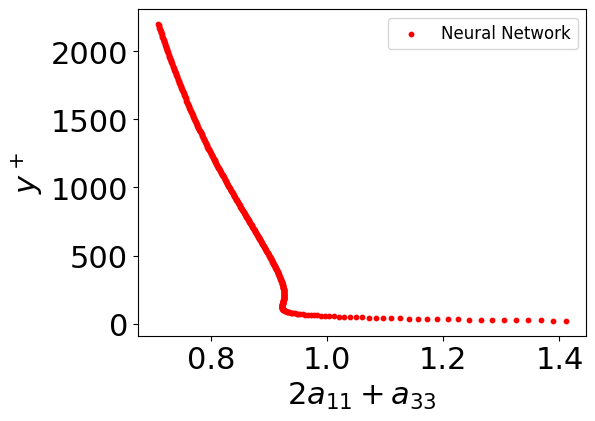

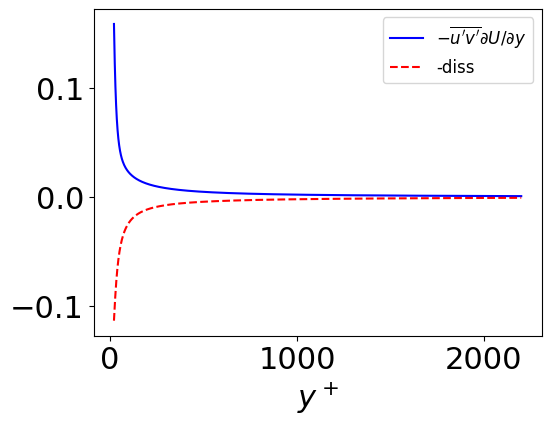

In [3]:
plot = True

if plot:
    ########################## 2*a11_DNS+a33_DNS
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    ax1.scatter(2*a11_DNS+a33_DNS,yplus_DNS, marker="o", s=10, c="red", label="Neural Network")
    plt.xlabel("$2a_{11}+a_{33}$")
    plt.ylabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/2a11_DNS+a33_DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-k-eps-units-BL.png')


    prod_DNS_1 = -uv_DNS*dudy_DNS

    ########################## k-bal
    fig1,ax1 = plt.subplots()
    plt.subplots_adjust(left=0.20,bottom=0.20)
    #ax1.plot(yplus_DNS_uu,prod_DNS, 'b-', label="prod")
    ax1.plot(yplus_DNS,prod_DNS_1, 'b-', label="$-\\overline{u'v'} \\partial U/\\partial y$")
    ax1.plot(yplus_DNS,-eps_DNS,'r--', label="-diss")
    #plt.axis([0,200,0,0.3])
    plt.xlabel("$y^+$")
    plt.legend(loc="best",fontsize=12)
    #plt.savefig('Output/prod-diss-DNS-dudy2-and-tau-2-hidden-9-yplus-2200-dudy-min-eq.4e-4-scale-with-ustar-and-nu-BL.png')



## Calculate $\frac{du}{dy}$ and $\frac{du}{dy}^2$

In [4]:
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()
scaler_dudy2 = MinMaxScaler()
scaler_dudy = MinMaxScaler()
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.fit_transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.fit_transform(dudy_DNS_inv_scaled)[:,0]



## Create training and test set 

In [5]:

# split the feature matrix and target vector into training and validation sets
# test_size=0.2 means we reserve 20% of the data for validation
# random_state=42 is a fixed seed for the random number generator, ensuring reproducibility

random_state = randrange(100)

indices = np.arange(len(X))

# Set test size to 0 for now
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, indices,test_size = 0.1 ,shuffle=True,random_state=42)

# convert the numpy arrays to PyTorch tensors with float32 data type
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

my_batch_size = 5
# create PyTorch datasets and dataloaders for the training and validation sets
# a TensorDataset wraps the feature and target tensors into a single dataset
# a DataLoader loads the data in batches and shuffles the batches if shuffle=True
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, shuffle=False, batch_size=my_batch_size)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=my_batch_size)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

# Assertions instead of plotting the data
for i, k in enumerate(index_train):
    assert abs(c_0_DNS[k] - train_dataset[i][1][0].numpy()) < 0.000001, "Training set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - train_dataset[i][1][1].numpy()) < 0.000001, "Training set for C2 differs from input values!"
    
for i, k in enumerate(index_test):
    assert abs(c_0_DNS[k] - test_dataset[i][1][0].numpy()) < 0.000001, "Test set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - test_dataset[i][1][1].numpy()) < 0.000001, "Test set for C2 differs from input values!"



## Train model

In [7]:

class nn_turbML(nn.Module):

    def __init__(self, nNodes):
        super(nn_turbML, self).__init__()
        self.linears = nn.ModuleList([nn.Linear(2, nNodes), nn.Linear(nNodes, nNodes), nn.Linear(nNodes,2)])
        self.actFunction = nn.Sigmoid()

    def forward(self, x):
        for i, linear in enumerate(self.linears):
            x = linear(x)
            # No activation function on output layer
            if i == len(self.linears)-1:
                break
            x = self.actFunction(x)
        return x

def closure():
    for batch, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()  # Zero out gradients
        outputs = model(X)  # Forward pass through the model
        loss = loss_fn(outputs, y)  # Compute mean squared error loss

        # Calculate the L1 regularization term
        l1_regularization = torch.tensor(0.)
        for param in model.parameters():
            l1_regularization += torch.norm(param, p=1)  # L1 norm of model parameters

        # Add the L1 regularization term to the loss
        loss += lambda_l1 * l1_regularization  # Add L1 regularization to the loss
        loss.backward()  # Compute gradients
    return loss
  

def test_loop(dataloader, model, loss_fn):
    global pred_numpy,pred1,size1
    size = len(dataloader.dataset)
    size1 = size
    num_batches = len(dataloader)
    test_loss = 0
    print('in test_loop: len(dataloader)',len(dataloader))

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
#transform from tensor to numpy
            pred_numpy = pred.detach().numpy()

    test_loss /= num_batches

    print(f"Avg loss: {test_loss:>.2e} \n")

    return test_loss

start_time = time.time()

# Instantiate a neural network
model = nn_turbML(100)

# Initialize the loss function
loss_fn = nn.MSELoss()
# Set up hyperparameters
learning_rate = 2.5e-1
max_epochs = 1000
lambda_l1 = 0.005
prev_loss = float('inf') 

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(max_epochs):
    loss = optimizer.step(closure)  # Optimize model parameters

    # Print the loss every 10th epoch
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}], Loss: {closure().item():.4f}")

    loss_change = prev_loss - loss.item()
    prev_loss = loss.item()

#test_loss = test_loop(test_loader, neural_net, loss_fn)


preds = model(X_test_tensor)

print(f"{'time ML: '}{time.time()-start_time:.2e}")

#transform from tensor to numpy
c_NN = preds.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c_0_DNS[index_test])/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS[index_test])/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)



Epoch [10], Loss: 6.6185
Epoch [20], Loss: 5.9869
Epoch [30], Loss: 5.4766
Epoch [40], Loss: 5.0468
Epoch [50], Loss: 4.6898
Epoch [60], Loss: 4.3922
Epoch [70], Loss: 4.1412
Epoch [80], Loss: 3.9234
Epoch [90], Loss: 3.7304
Epoch [100], Loss: 3.5545
Epoch [110], Loss: 3.3925
Epoch [120], Loss: 3.2398
Epoch [130], Loss: 3.4496
Epoch [140], Loss: 3.4338
Epoch [150], Loss: 3.2694
Epoch [160], Loss: 3.1528
Epoch [170], Loss: 3.0430
Epoch [180], Loss: 2.9328
Epoch [190], Loss: 2.8186
Epoch [200], Loss: 2.7044
Epoch [210], Loss: 2.5911
Epoch [220], Loss: 2.4824
Epoch [230], Loss: 2.3759
Epoch [240], Loss: 2.2708
Epoch [250], Loss: 2.1744
Epoch [260], Loss: 2.0898
Epoch [270], Loss: 2.0117
Epoch [280], Loss: 1.9442
Epoch [290], Loss: 1.8838
Epoch [300], Loss: 1.8228
Epoch [310], Loss: 1.7687
Epoch [320], Loss: 1.7258
Epoch [330], Loss: 1.6813
Epoch [340], Loss: 1.6381
Epoch [350], Loss: 1.6012
Epoch [360], Loss: 1.5657
Epoch [370], Loss: 1.5328
Epoch [380], Loss: 1.4999
Epoch [390], Loss: 1.

## Validate with boundary layer flow 

In [8]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('BoundaryLayer', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()

## We have to use the same scaler as for the training data set
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

X = torch.tensor(X, dtype=torch.float32)

predictions_Boundary = model(X)

c_NN = predictions_Boundary.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c_0_DNS)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)


Returning data from: BoundaryLayer. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.015961567837113555

c2_error_std:  0.005561918178426092


## Validate with channel flow, $Re = 550$ 

In [9]:
y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re550' , 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]
# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
# scale with k and eps 
# dudy [1/T]
# dudy**2 [1/T**2]
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
# re-shape
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
# use MinMax scaler
#scaler_dudy2 = StandardScaler()
#scaler_tau = StandardScaler()

## We have to use the same scaler as for the training data set
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

X = torch.tensor(X, dtype=torch.float32)

predictions_Boundary = model(X)

c_NN = predictions_Boundary.detach().numpy()
 
c_NN_old = c_NN

c0=c_NN[:,0]
c2=c_NN[:,1]

c0_std=np.std(c0-c_0_DNS)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

Returning data from: FullyDevelopedChannel_Re550. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33

c0_error_std:  5.546086975285185

c2_error_std:  3.0229551482401655


## Assignment 2b 
### RandomForestRegressor

In [18]:
import time
import numpy as np
from sklearn.ensemble import RandomForestRegressor
#from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


#Dataset to train
#Fully developed plane turbulent channel flow Re=5200

y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re5200', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

# transpose the target vector to make it a column vector  
y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)
scaler_dudy2 = MinMaxScaler()
scaler_dudy = MinMaxScaler()
X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.fit_transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.fit_transform(dudy_DNS_inv_scaled)[:,0]

random_state = randrange(100)
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, indices,test_size = 0.1 ,shuffle=True,random_state=42)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

X_train_tensor = torch.tensor(X_train)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

for i, k in enumerate(index_train):
    assert abs(c_0_DNS[k] - train_dataset[i][1][0].numpy()) < 0.000001, "Training set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - train_dataset[i][1][1].numpy()) < 0.000001, "Training set for C2 differs from input values!"
for i, k in enumerate(index_test):
    assert abs(c_0_DNS[k] - test_dataset[i][1][0].numpy()) < 0.000001, "Test set for C0 differs from input values!"
    assert abs(c_2_DNS[k] - test_dataset[i][1][1].numpy()) < 0.000001, "Test set for C2 differs from input values!"
    
start_time = time.time()

n_estimators = 100  #number of trees
model_forest = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
model_forest.fit(X_train, y_train)
preds = model_forest.predict(X_test)
print(f"{'time ML: '}{time.time()-start_time:.2e}")

c0 = preds[:, 0]
c2 = preds[:, 1]
c0_std = np.std(c0 - c_0_DNS[index_test]) / (np.mean(c0.flatten()**2))**0.5
c2_std = np.std(c2 - c_2_DNS[index_test]) / (np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ', c0_std)
print('\nc2_error_std: ', c2_std)

#improvement in training time

Returning data from: FullyDevelopedChannel_Re5200. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33
time ML: 2.63e-01

c0_error_std:  0.10881616256946057

c2_error_std:  0.022427959984021327


In [19]:
#prediction on boundary layer
#turbulent zero-pressure gradient boundary layer

y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('BoundaryLayer', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)

X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

predictions_Boundary_forest = model_forest.predict(X)

c_NN_forest = predictions_Boundary_forest

c0=c_NN_forest[:,0]
c2=c_NN_forest[:,1]
c0_std=np.std(c0-c_0_DNS)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)


Returning data from: BoundaryLayer. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33

c0_error_std:  0.18029881497229838

c2_error_std:  0.11589465740761133


In [20]:
#prediction on channel flow
#fully developed plane turbulent channel flow Re=550

y_DNS, yplus_DNS, u_DNS, uu_DNS, vv_DNS, ww_DNS, uv_DNS, k_DNS, eps_DNS, dudy_DNS = GetInputData('FullyDevelopedChannel_Re550', 20, 2200)
c, a11_DNS, a33_DNS = GetC0andC2(k_DNS, eps_DNS, dudy_DNS, uu_DNS, vv_DNS, ww_DNS)

c_0_DNS = c[0, :]
c_2_DNS = c[1, :]

y = c.transpose()
tau_DNS = abs(k_DNS/eps_DNS)
dudy_squared_DNS = (dudy_DNS**2)
T = tau_DNS
dudy_squared_DNS_scaled = dudy_squared_DNS*T**2
dudy_DNS_inv = 1/dudy_DNS/T
dudy_squared_DNS_scaled = dudy_squared_DNS_scaled.reshape(-1,1)
dudy_DNS_inv_scaled = dudy_DNS_inv.reshape(-1,1)

X=np.zeros((len(dudy_DNS),2))
X[:,0] = scaler_dudy2.transform(dudy_squared_DNS_scaled)[:,0]
X[:,1] = scaler_dudy.transform(dudy_DNS_inv_scaled)[:,0]

predictions_channel_forest = model_forest.predict(X)

c_NN_forest = predictions_channel_forest

c0=c_NN_forest[:,0]
c2=c_NN_forest[:,1]
c0_std=np.std(c0-c_0_DNS)/(np.mean(c0.flatten()**2))**0.5
c2_std=np.std(c2-c_2_DNS)/(np.mean(c2.flatten()**2))**0.5

print('\nc0_error_std: ',c0_std)
print('\nc2_error_std: ',c2_std)

#Error is lower compared to our hand-coded Neural Network

Returning data from: FullyDevelopedChannel_Re550. Min yplus: 20. Max yplus: 2200
Returning c = [c0, c2], a11 and a33

c0_error_std:  63.49254395628147

c2_error_std:  39.7678263225783
